In [14]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg
import scipy.sparse.linalg as spla
import time
%matplotlib inline

In [15]:
import importlib.util
import checker
import test.test_generator as generator

importlib.reload(checker)
importlib.reload(generator)

{'payoutNaive': 87267, 'payoutRepeatedColumns': 59089, 'payoutSparse': 88218}


<module 'test.test_generator' from '/Users/maksimshuklin/hse/coursework/test/test_generator.py'>

In [16]:
n = 50
matrix = generator.generate_sparse(n, n)
assets_cost = [i for i in range(n)]

In [17]:
checker.get_timings(matrix, assets_cost)

{'payoutNaive': 4292791,
 'payoutRepeatedColumns': 4659037,
 'payoutSparse': 2235478}

In [18]:
X = [i * 10 for i in range(1, 9)]
naive = []
sparse = []
repeated_cols = []
for x in X:
    matrix = generator.generate_sparse(x, x)
    assets_cost = [i for i in range(x)]
    j = checker.get_timings(matrix, assets_cost)
    naive.append(j['payoutNaive'])
    sparse.append(j['payoutSparse'])
    repeated_cols.append(j['payoutRepeatedColumns'])

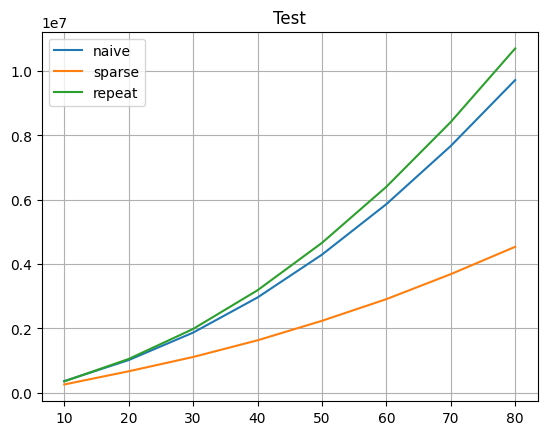

In [21]:
plt.plot(X, np.c_[naive, sparse, repeated_cols])
plt.legend(["naive", "sparse", "repeat"])
plt.title("Test")
plt.grid(True)
plt.show()

# Тестируем реализации

На данный момент мною реализовано 4 алгоритма для payout-функции:

1. Наивная реализация: `payoutNaive`. Хранит матрицу в несжатом виде, алгоритм выплаты – наивный
2. Алгоритм для разреженной матрицы: `payoutSparse`. Хранит матрицу в сжатом виде (формат *COO*)
3. Алгоритм для дублирующихся столбцов: `payoutRepeatedColumns`. Хранит матрицу в сжатом виде
4. Алгоритм для малоранговой матрицы: `payoutLowRank`. Случай повторяющихся столбцов *(3)* является частным случаем малоранговой матрицы, но при этом в нем можно сделать более эффективную оптимизацию количества газа.

Посмотрим, какие преимущества дает каждый из алгоритмов. Для этого протестируем эти алгоритмы для различных наборах входных данных:
* Плотные матрицы
* Разреженные матрицы (степень разреженности задается параметров `capacity`)
* Матрицы с повторяющимися столбцами
* Малоранговые матрицы
* Квадратные матрицы
* Прямоугольные высокие матрицы и прямоугольные широкие матрицы

### Плотные матрицы

**Плотная матрица** – это матрица, в которой мало нулевых элементов. Не будем предполагать, что у этой матрицы есть какая-то особенная структура (малый ранг, повторяющиемся столбцы/элементы и т.д.)

Посмотрим, сколько газа потребляет каждый из алгоритмов в данном случае:

In [7]:
def get_gas_info_dense(X):
    naive = []
    sparse = []
    repeated_cols = []
    for x in X:
        matrix = generator.generate_random(x, x)
        assets_cost = [i for i in range(x)]
        j = checker.get_timings(matrix, assets_cost)
        naive.append(j.get('payoutNaive'))
        sparse.append(j.get('payoutSparse'))
        repeated_cols.append(j.get('payoutRepeatedColumns'))
    return naive, sparse, repeated_cols

In [8]:
X_dense = [10 * i for i in range(1, 9)]
naive, sparse, repeated_cols = get_gas_info_dense(X_dense)

In [9]:
print(naive)
print(sparse)
print(repeated_cols)

[404527, 1021375, 1878915, 2977279, 4316491, 5896731, None, None]
[469182, 1318954, 2556838, 4207242, None, None, None, None]
[391933, 1056079, 1992541, 3201415, 4682737, 6436675, None, None]


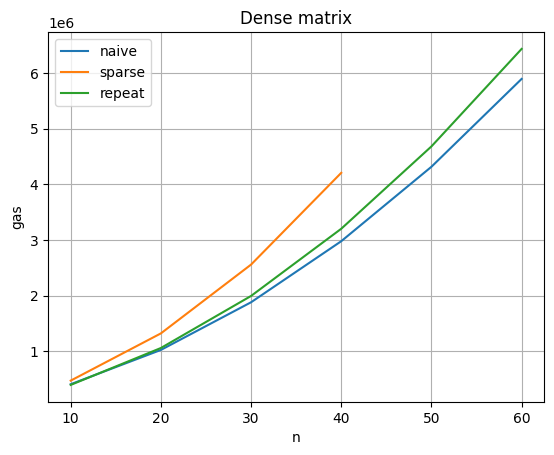

In [10]:
plt.plot(X_dense, np.c_[naive, sparse, repeated_cols])
plt.legend(["naive", "sparse", "repeat"])
plt.xlabel("n")
plt.ylabel("gas")
plt.title("Dense matrix")
plt.grid(True)
plt.show()

**Вывод:**

Видно, что с плотными матрицами быстрее работает алгоритм `payoutNaive`, который рассчитывает размер диведендов и хранит матрицу в явном виде без каких-либо оптимизаций.

При этом, как можно видеть, алгоритм `payoutSparse`, предназначенных для разреженных матриц, работает заметно хуже других алгоритмов. Это можно легко объясняется следующим фактом: для разреженной матрицы с $k$ элементами требуется хранить 3 массива размера $k$, что в случае плотных занимает в $3$ раза больше пямяти, чем наивный подход.

### Разреженные матрицы

**Разреженная матрица** – это матрица, в которой много нулей (обычно больше, чем ненулевых элементов). Не будем предполагать в этом пункте, что у матрицы есть какая-либо дополнительная структура, кроме разреженности.

Посмотрим, каким образом будет вести себя количество потребляемого газа в зависимости от используемого алгоритма и степени разреженности матрицы (`capacity`):

In [11]:
def get_gas_info_sparse(X, capacity = 20):
    naive = []
    sparse = []
    repeated_cols = []
    for x in X:
        matrix = generator.generate_sparse(x, x)
        assets_cost = [i for i in range(x)]
        j = checker.get_timings(matrix, assets_cost)
        naive.append(j['payoutNaive'])
        sparse.append(j['payoutSparse'])
        repeated_cols.append(j['payoutRepeatedColumns'])
    return naive, sparse, repeated_cols

In [12]:
X_sparse = [10 * i for i in range(1, 9)]
naive, sparse, repeated_cols = get_gas_info_sparse(X_sparse, 20)

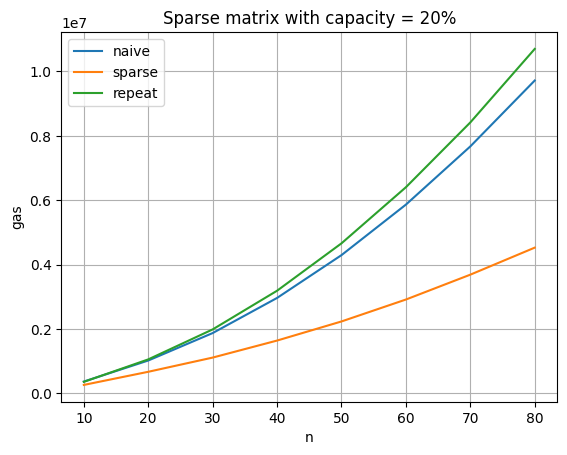

In [13]:
plt.plot(X_sparse, np.c_[naive, sparse, repeated_cols])
plt.legend(["naive", "sparse", "repeat"])
plt.xlabel("n")
plt.ylabel("gas")
plt.title("Sparse matrix with capacity = 20%")
plt.grid(True)
plt.show()

**Вывод:**

Видно, что алгоритм для разреженных матриц заметно выигрывает (разница более чем в два раза).

При этом, что интересно подметить, алгоритм `payoutRepeatedColumns` для матриц с одинаковыми столбцами несколько медленне, чем наивный `payoutNaive`. Объяснить этом можно тем, что из-за особенности хранения данных в `payoutRepeatedColumns`, на матрицах без нужной структуры есть небольшой оверхед, по сравнению с `payoutNaive`

### Повторяющиеся столбцы

Под матрицей с повторяющимися столбцами будем подразумевать следующее:

* Пусть есть некоторый набор столбцов $A_1, \ldots, A_k$, где $k << n$
* Тогда искомая матрица $A \in \mathbb{R}^{n \times n}$ имеет вид:
$$
A = \left( A_{i_1} | A_{i_2} | \ldots | A_{i_n} \right) \text{, где } i_j = 1 \ldots k
$$